Setting up environment

In [ ]:
# Importing necessary libraries

from google.colab import drive
drive.mount('/content/drive')

!pip install hic-straw

import tensorflow as tf # tensorflow 2.x
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Activation, Dropout, Lambda, Conv2DTranspose, AveragePooling2D
from keras.models import Model
from keras import backend as K
from matplotlib import pyplot as plt
import matplotlib
import time
import numpy as np
from scipy import stats
from keras import metrics
import random
import math
import statistics
import hicstraw
import csv
import seaborn as sns
from scipy.signal.windows import gaussian
import os
import shutil

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting up global variables

WIDTH=10
res=1000000
br = matplotlib.colors.LinearSegmentedColormap.from_list("bright_red",[(1,1,1),(1,0,0)])
np.set_printoptions(suppress=True)
folder = "/content/drive/MyDrive/Chirag/Data/Equids HIC to Numpy (1 MB)/"
model = tf.keras.models.load_model('/content/drive/MyDrive/Chirag/Models/BinaryClassifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)          │ (None, 10, 10, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_84 (Conv2D)                   │ (None, 10, 10, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_85 (Conv2D)                   │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 100)                 │         640,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,392,788 (5.31 MB)

 Trainable params: 696,393 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 696,395 (2.66 MB)

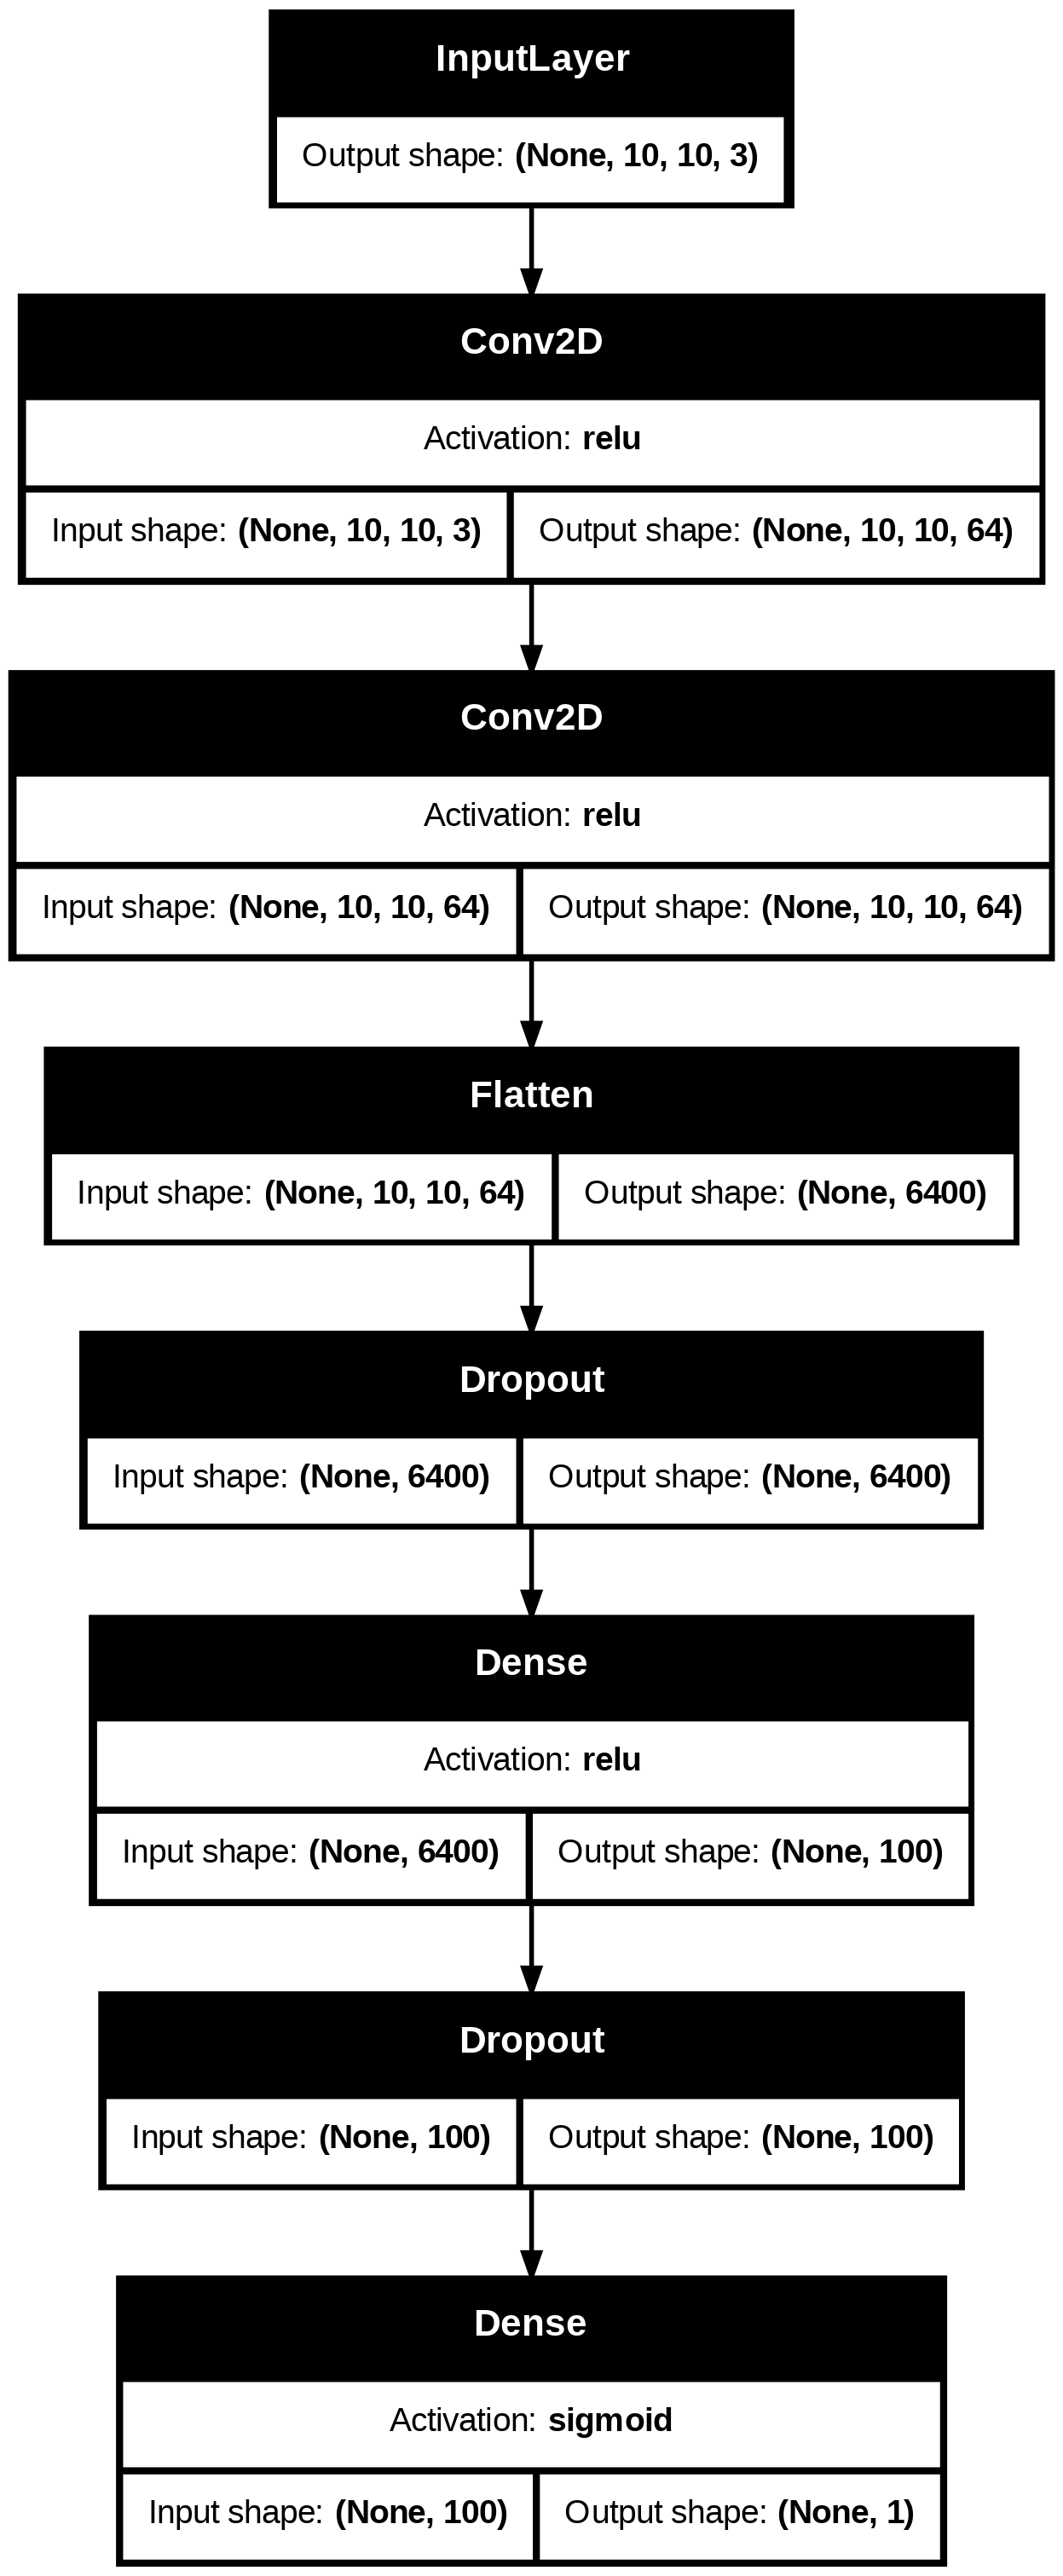

In [ ]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True) # Visualizing model

In [ ]:
# Loading in hic files

!wget https://www.dropbox.com/sh/3eh3lbzedwc0hrg/AABCOB3Zjebx87K5fLr6HZfsa/HIC784_deep.hic
!wget https://www.dropbox.com/sh/3eh3lbzedwc0hrg/AABYTADxb2eShDPUpUn77RV0a/HIC785_deep.hic
!wget https://www.dropbox.com/sh/3eh3lbzedwc0hrg/AADb5Ow50xQjiE94h5bor4Rsa/HIC787_deep.hic
!wget https://www.dropbox.com/sh/3eh3lbzedwc0hrg/AABrggqW2HPxT5T2aoXvgoOja/HIC788_deep.hic
!wget https://www.dropbox.com/sh/3eh3lbzedwc0hrg/AABHmvN7KxvYvaQgbNwKceFha/HIC1024_deep.hic
!wget https://www.dropbox.com/sh/3eh3lbzedwc0hrg/AACYLN_2wPbwPEjz6aXrxlY4a/HIC1026_deep.hic

files = ["HIC784_deep.hic",
         "HIC785_deep.hic",
         "HIC787_deep.hic",
         "HIC788_deep.hic",
         "HIC1024_deep.hic",
         "HIC1026_deep.hic"]

--2024-08-18 14:49:24--  https://www.dropbox.com/sh/3eh3lbzedwc0hrg/AABCOB3Zjebx87K5fLr6HZfsa/HIC784_deep.hic
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/3eh3lbzedwc0hrg/AABCOB3Zjebx87K5fLr6HZfsa/HIC784_deep.hic [following]
--2024-08-18 14:49:25--  https://www.dropbox.com/sh/raw/3eh3lbzedwc0hrg/AABCOB3Zjebx87K5fLr6HZfsa/HIC784_deep.hic
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb1af4152ac7f2f3d71fcea1d2a.dl.dropboxusercontent.com/cd/0/inline/CY5WkfgSgqeSyXvwCW-4MBbX0hvI1na1Sbr6lJtDsifUYD9cJbpycegtCKdg9rRbYxGcqS4nXhoEVU3JPZ6kZfzpdaPteCwY42qzAgx6ZVPVsck9QOdDoblESVdiXHyvavySIeiGn-yJ2kqp7OtpGnyp/file# [following]
--2024-08-18 14:49:25--  https://ucb1af4152ac7f2f3d71fcea1d2a.dl.dropboxusercontent.com/cd/0/inline/CY5WkfgSgqeS

Preprocessing and helper functions

In [ ]:
# Performing Gaussian blurring on an image

def gaussian_kernel(kernel_size, std):
    gk1d = gaussian(kernel_size, std).reshape(kernel_size, 1)
    gk2d = np.outer(gk1d, gk1d)
    return gk2d/gk2d.sum()

kernel_size = 5
std_dev = 1.0
gauss_kernel = gaussian_kernel(kernel_size, std_dev)

def blur(image_matrix, gauss_kernel, kernel_size):
  image_tensor = tf.reshape(image_matrix, [1, *image_matrix.shape, 1])
  gauss_kernel_tensor = tf.convert_to_tensor(gauss_kernel, dtype=image_tensor.dtype)
  gauss_kernel_tensor = tf.reshape(gauss_kernel_tensor, [kernel_size, kernel_size, 1, 1])
  blurred_image = tf.nn.conv2d(image_tensor, gauss_kernel_tensor, strides=[1, 1, 1, 1], padding="SAME")
  return blurred_image.numpy().squeeze()

In [ ]:
# OE functions

# Averages out each diagonal
# For symmetric matrices, return an array with the values on each diagonal replaced by the average of that diagonal
def replace_diagonal_with_average(arr):
  max_offset = arr.shape[0]
  for i in range(1, max_offset):
    np.fill_diagonal(arr[:i, max_offset-i:], np.mean(np.diagonal(arr, offset=max_offset-i)))
    np.fill_diagonal(arr[max_offset-i:, :i], np.mean(np.diagonal(arr, offset=i-max_offset)))
  np.fill_diagonal(arr, np.mean(np.diagonal(arr)))

  return arr

# Return a WIDTH * WIDTH array of a near-diagonal expected matrix

def get_expected_matrix(hic, res, WIDTH, sample_size = 20, data_type = 'observed', normalization = 'NONE', unit = 'BP'):
  expected_matrix = np.zeros([WIDTH, WIDTH])
  expected_matrices = np.zeros([sample_size, WIDTH, WIDTH])
  chroms = hic.getChromosomes()
  num_chroms = len(chroms)-1
  for i in range(sample_size): # Sample of matrices taken
    scaffold = int(random.random()*num_chroms)+1 # Choosing random chromosome
    chr1_start = int(random.random()*(chroms[scaffold].length//res-(WIDTH-1))) * res # Choosing random start point
    matrix = hic.getMatrixZoomData(chroms[scaffold].name, chroms[scaffold].name, data_type, normalization, unit, res)
    matrix = matrix.getRecordsAsMatrix(chr1_start, chr1_start+(WIDTH-1)*res, chr1_start, chr1_start+(WIDTH-1)*res)
    expected_matrices[i, :, :] = replace_diagonal_with_average(matrix) # Creating expected matrix

  for i in range(WIDTH):
    for j in range(WIDTH):
      expected_matrix[i, j] = np.median(expected_matrices[:, i, j]) # Taking median of expected matrices to prevent skew from abnormal examples

  return expected_matrix

In [ ]:
# Centile Rescaling

# Capping the matrix at a certain threshold and then linearly scaling between 0 and 1

def globalPercentileProcess(matrix, threshold):
  return np.where(matrix<threshold, matrix, threshold)/threshold

# Determine numerical value for centile
# Done very similarly to get_expected_matrix function above

def get_med_threshold(hic, centiles, res, WIDTH, sample_size = 20, data_type = 'observed', normalization = 'NONE', unit = 'BP'):
  thresholds=np.zeros([len(centiles), sample_size])
  chroms = hic.getChromosomes()
  num_chroms = len(chroms)-1

  for i in range(sample_size):
    chrom = int(random.random()*num_chroms)+1
    chr1_start = int(random.random()*(chroms[chrom].length//res-(WIDTH-1)))
    matrix = hic.getMatrixZoomData(chroms[chrom].name, chroms[chrom].name, data_type, normalization, unit, res)
    matrix = matrix.getRecordsAsMatrix(chr1_start, chr1_start+(WIDTH-1)*res, chr1_start, chr1_start+(WIDTH-1)*res)

    for idx, centile in enumerate(centiles):
      thresholds[idx, i] = np.percentile(matrix, centile) # Centile threshold calculated for each matrix

  final_thresholds = list()
  for i in range(len(centiles)):
    final_thresholds.append(statistics.median(thresholds[i]))

  return final_thresholds

Deploying to find breaks

In [ ]:
# name is file name
# folder is the location where the matrices for each hic file are located
def runOnHIC(hic, res, WIDTH, name, centiles, folder, model):
  thresholds = get_med_threshold(hic, centiles, res, WIDTH)
  chroms = hic.getChromosomes()

  with open(name + '.bed', 'w') as f:
    f.write("#chr1\tx1\tx2\tbin\n")
    f.write("# thresholds: " + str(thresholds) + "\n")

    for idx, chrom in enumerate(chroms[1:]):
      chrom_matrix = np.load(folder+chrom.name+".npy") # Opening matrix with stored matrices of the chromosome
      input_matrix = np.zeros([chrom_matrix.shape[0], WIDTH, WIDTH, len(centiles)])

      for idx in range(len(centiles)):
        input_matrix[:, :, :, idx] = globalPercentileProcess(chrom_matrix, thresholds[idx]) # Preprocessing with centiles matrix

      predictions = model.predict(input_matrix)# Predicting

      for idx in range(len(predictions)): # Writing to bed file
        f.write(chrom.name + "\t")
        f.write(str(res*(idx+WIDTH//2-1))+"\t") # Location of region being examined
        f.write(str(res*(idx+WIDTH//2))+"\t")
        f.write(str(round(predictions[idx][0], 4))+"\n") # Prediction of the model

In [ ]:
# Deployment

for file in files:
  print(file)
  root = folder + file.split(".")[0]+"_matrices/"
  hic = hicstraw.HiCFile(file)
  runOnHIC(hic, res, WIDTH, file, [95, 90, 80], root, model)

In [ ]:
# Folder to save results in
folder_results = "/content/drive/MyDrive/Chirag/Results/Binary Classifier (1 MB)/"
if not os.path.exists(folder_results):
  os.mkdir(folder_results)

In [ ]:
for file in files:
  shutil.move(file + ".bed", folder_results) # Moving file to folder

Cleaning and modifying output files

In [ ]:
# Converting chromosome names to their chromosome number, starting from 1
# Necessary for when files have different chromosome names

def chrom_to_index(hic, bed_file, output_file):

  chroms = hic.getChromosomes()
  chrom_names = [chrom.name for chrom in chroms]

  with open(output_file, 'w') as o:
    with open(bed_file, 'r') as file:
      for line in file:
        if line.startswith('#'): # Keep lines with comments the dame
          o.write(line)
          continue
        parts = line.strip().split('\t')
        chrom = chrom_names.index(parts[0]) # Getting the chromosome index
        new_line = line.replace(parts[0], str(chrom))
        o.write(new_line) # Writing new line to the file

for file in files:
  hic = hicstraw.HiCFile(file)
  chrom_to_index(hic, folder_results + file + '.bed', file+'.indexes.bed')

In [ ]:
# Cleaning output files
# Any probabilty greater than break_threshold indicates a break
def filter_bed_by_bins(input_bed_path, output_bed_path, break_threshold):
    # Open the input BED file and the output file
    with open(input_bed_path, 'r') as infile, open(output_bed_path, 'w') as outfile:
        for line in infile:
            # Check if the line is a header
            if line.startswith('#'):
                # Write the header to the output file
                outfile.write(line)
            else:
                # Parse the line
                parts = line.strip().split('\t')
                # Assuming 'bin' is the last column in your BED file
                bin_value = float(parts[-1])
                # Check if the bin is in the list and its index
                if bin_value > break_threshold: # Only breaks greater than a certain threshold were considered
                    outfile.write(line)

# Sorting bed file by chromosome and break location
def sort_bed_file(input_file, output_file):
    # Read the input file into a list of tuples
    with open(input_file, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        bed_list = [row for row in reader if not row[0].startswith('#')] # Grabbing all non-commented lines

    # Sort the list by chromosome and start position
    sorted_bed = sorted(bed_list, key=lambda x: (int(x[0]), int(x[1])))

    # Write the sorted list to the output file
    with open(output_file, 'w') as out:
        writer = csv.writer(out, delimiter='\t')
        writer.writerows(sorted_bed)

# Merging breaks that are likely to be a single break
# If the distance between breaks is greater than same_break_distance, they are considered to be different breaks
def merge_features(input_file, output_file, same_break_distance):
    # Read the input file
    with open(input_file, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        # Sort by chromosome and start position
        features = sorted([row for row in reader], key=lambda x: (int(x[0]), int(x[1])))

    # Merge features
    merged_features = []
    current_feature = None
    for feature in features:
        chrom, start, end, prob = feature
        start, end = int(start), int(end)
        prob = float(prob)

        # If the breaks are within a certain distance of each other, they are considered to be the same break
        if current_feature and chrom == current_feature[0] and start - current_feature[2] <= same_break_distance:
            # Merge with current_feature
            current_feature[2] = max(current_feature[2], end)
            if prob > current_feature[3]:
                current_feature[3] = prob
        else:
            # Start a new feature
            if current_feature:
                merged_features.append(current_feature)
            current_feature = [chrom, start, end, prob]

    if current_feature:
        merged_features.append(current_feature)

    # Write the merged features to the output file
    with open(output_file, 'w', newline='') as out:
        writer = csv.writer(out, delimiter='\t')
        writer.writerows(merged_features)

In [ ]:
break_threshold = 0.495
same_break_distance = 500000 # 500 KB
for file in files:
  filter_bed_by_bins('/content/' + file + '.indexes.bed', 'breaks.bed', break_threshold)
  sort_bed_file('breaks.bed', 'sorted.bed')
  merge_features('sorted.bed', file+'.breaks.bed', same_break_distance)

Creating merged list of breaks across all files

In [ ]:
# Merging annotations among all files

# Grabbing location of features and removing all comments
def parse_bed_file(bed_file):
    annotations = []
    with open(bed_file, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            parts = line.strip().split('\t')
            annotations.append((parts[0], int(parts[1]), int(parts[2])))
    return annotations

# Merging annotations that overlap
# The beginning of the merged annotation is the minimum of all annotations and the end is the maximum
def merge_annotations(annotations):
    merged = []
    for ann in sorted(annotations, key=lambda x: (int(x[0]), x[1])):
        if not merged or merged[-1][0] != ann[0] or merged[-1][2] < ann[1]:
            merged.append(list(ann))  # Convert tuple to list for modification
        else:
            merged[-1][2] = max(merged[-1][2], ann[2])
    return merged

# Collecting all annotations from among the different files
def merge_all_annotations(bed_files):
    all_annotations = []
    for bed_file in bed_files:
        annotations = parse_bed_file(bed_file)
        all_annotations.extend(annotations)
    return merge_annotations(all_annotations)

# Keeping track of which features show up in which bed files
def create_matrix_and_annotations_list(bed_files):
    merged_annotations = merge_all_annotations(bed_files)

    annotations_dict = {}
    all_annotations = []
    for ann in merged_annotations:
        all_annotations.append(ann)
        key = tuple(ann)
        if key not in annotations_dict:
            # Tracking which files each annotation is present in
            annotations_dict[key] = [1 if any(bed_ann[0] == ann[0] and bed_ann[1] >= ann[1] and bed_ann[2] <= ann[2] for bed_ann in parse_bed_file(bed_file)) else 0 for bed_file in bed_files]

    # Convert dictionary to NumPy matrix
    matrix = np.array(list(annotations_dict.values()))

    return matrix, all_annotations

# Example usage
bed_files = ["/content/HIC784_deep.hic.breaks.bed", "/content/HIC785_deep.hic.breaks.bed",
             "/content/HIC787_deep.hic.breaks.bed", "/content/HIC788_deep.hic.breaks.bed",
             "/content/HIC1024_deep.hic.breaks.bed", "/content/HIC1026_deep.hic.breaks.bed"]
matrix, all_annotations = create_matrix_and_annotations_list(bed_files)

# Printing the matrix

for i in range(matrix.shape[0]):
  print(all_annotations[i], matrix[i])

['2', 48000000, 50000000] [1 1 1 1 0 1]
['3', 16000000, 17000000] [0 1 0 0 1 1]
['3', 36000000, 37000000] [1 1 1 1 0 1]
['4', 25000000, 26000000] [1 1 0 0 0 0]
['5', 17000000, 18000000] [0 0 0 0 1 1]
['5', 48000000, 50000000] [1 1 1 1 0 1]
['5', 60000000, 61000000] [0 0 1 0 1 1]
['6', 27000000, 28000000] [1 1 1 1 0 1]
['7', 5000000, 6000000] [1 1 1 1 0 1]
['7', 52000000, 53000000] [0 0 0 0 0 1]
['8', 30000000, 31000000] [1 1 1 1 0 1]
['10', 28000000, 29000000] [1 1 1 1 0 1]
['10', 55000000, 56000000] [1 1 0 0 0 0]
['11', 7000000, 8000000] [0 0 0 0 0 1]
['11', 26000000, 27000000] [0 0 1 1 1 1]
['12', 12000000, 13000000] [1 1 1 1 1 0]
['13', 12000000, 13000000] [0 0 1 1 1 0]
['15', 19000000, 20000000] [1 1 0 1 1 0]
['15', 27000000, 28000000] [0 0 0 0 1 0]
['15', 50000000, 51000000] [1 0 0 0 0 0]
['23', 49000000, 50000000] [1 1 1 1 1 1]
['24', 23000000, 24000000] [0 0 0 0 0 1]
['24', 31000000, 32000000] [0 0 0 1 0 0]
['28', 33000000, 34000000] [0 0 0 0 1 1]


Visualizing breaks heatmap across all files

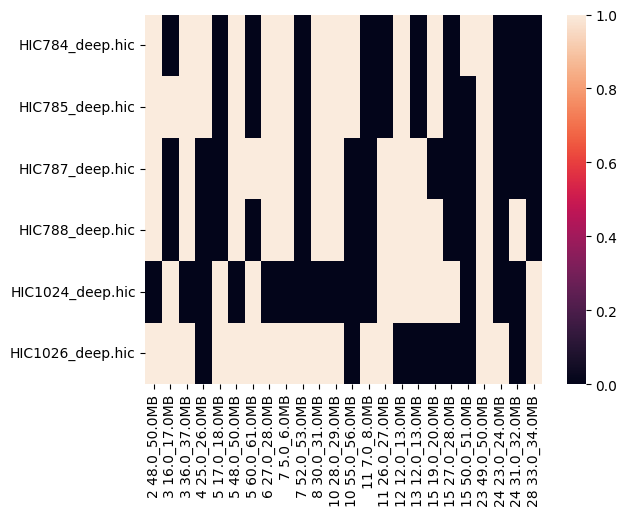

In [ ]:
# Visual of which breaks are present in which files
xticklabels = [i[0] + " " + str(i[1]/1000000) + "_" + str(i[2]/1000000) + "MB" for i in all_annotations] # Converting break location to readable format

ax = sns.heatmap(data = np.transpose(matrix), xticklabels = xticklabels, yticklabels = files)
plt.show()

Creating list of free ends

In [ ]:
# Creating list of free ends

def create_breakage_matrix(hic, all_annotations, res, WIDTH):
  chroms = hic.getChromosomes()
  num_chroms = len(chroms)-1 # number of chromosomes
  idx=0
  breakages = []
  for chrom in range(1, num_chroms+1): # Iterating through each chromosome
    # Each free end is defined by its orientation, chromosome, and chromosome location in that order
    details = (0, chrom, 0) # Adding the head of each chromosome
    breakages.append(details)
    while not idx == len(all_annotations) and int(all_annotations[idx][0]) == chrom: # Checking if there is a break in the chromosome
      details = (1, chrom, all_annotations[idx][1]-(WIDTH//2)*res) # Tail of the break
      breakages.append(details)
      details = (0, chrom, all_annotations[idx][2]) # Head of the break
      breakages.append(details)
      idx+=1

    details = (1, chrom, (chroms[chrom].length//res-WIDTH//2) * res) # Adding the tail of each chromosome
    breakages.append(details)

  return breakages

hic = hicstraw.HiCFile(files[0]) # one file needed to get length of each chromosome
breakages = create_breakage_matrix(hic, all_annotations, res, WIDTH)

Fusions helper functions

In [ ]:
# p1 and p2 are the positions in the chromosome
# o1 and o2 are the orientations of each piece, 0 is head and 1 is tail

def grabFromStraw(hic, res, chr1, p1, chr2, p2, WIDTH, data_type = 'observed', normalization = 'NONE', unit = 'BP'):

  matrix_chr1 = hic.getMatrixZoomData(chr1, chr1, data_type, normalization, unit, res)
  matrix_chr1 = matrix_chr1.getRecordsAsMatrix(p1, p1 + (WIDTH//2-1)*res, p1, p1 + (WIDTH//2-1)*res)

  matrix_chr2 = hic.getMatrixZoomData(chr2, chr2, data_type, normalization, unit, res)
  matrix_chr2 = matrix_chr2.getRecordsAsMatrix(p2, p2 + (WIDTH//2-1)*res, p2, p2 + (WIDTH//2-1)*res)

  matrix_comb = hic.getMatrixZoomData(chr1, chr2, data_type, normalization, unit, res)
  matrix_comb = matrix_comb.getRecordsAsMatrix(p1, p1 + (WIDTH//2-1)*res, p2, p2 + (WIDTH//2-1)*res) # Grabbing common region

  return matrix_chr1, matrix_chr2, matrix_comb

def getRegion(hic, res, chr1, p1, o1, chr2, p2, o2, WIDTH, data_type = 'observed', normalization = 'NONE', unit = 'BP'):

  matrix_chr1, matrix_chr2, matrix_comb = grabFromStraw(hic, res, chr1, p1, chr2, p2, WIDTH, data_type = data_type, normalization = normalization, unit = unit)

  type_break = o1*2+o2 # Each combination of break gives a different value for type_break
  output = np.zeros([WIDTH, WIDTH])

  # Stitching the matrices together with particular transformations for each value of type_break to create the proper chimeric matrix

  if type_break==0: # Both free ends are a head
    matrix_chr1 = np.flip(matrix_chr1, (0, 1))
    common1 = np.flipud(matrix_comb)
    common2 = np.rot90(matrix_comb, axes=(1, 0))

  elif type_break==1: # First region is a head, second region is a tail
    matrix_chr1 = np.flip(matrix_chr1, (0, 1))
    matrix_chr2 = np.flip(matrix_chr2, (0, 1))
    common1 = np.fliplr(np.flipud(matrix_comb))
    common2 = np.flipud(np.rot90(common1))

  elif type_break==2: # First region is a tail, second region is a head
    common1 = matrix_comb
    common2 = np.rot90(np.fliplr(matrix_comb))

  else: # First region is a tail, second region is a tail
    matrix_chr2 = np.flip(matrix_chr2, (0, 1))
    common1 = np.fliplr(matrix_comb)
    common2 = np.rot90(matrix_comb)

  i=WIDTH//2

  # Placing the smaller matrices in the final matrix

  output[:i, :i] = matrix_chr1
  output[i:, i:] = matrix_chr2
  output[:i, i:] = common1
  output[i:, :i] = common2

  return output

def visualizeFusions(hic, chr1, p1, o1, chr2, p2, o2, res, WIDTH, centiles = [], centiles_results_modified = [], oe_preprocess = [], model=None): # 0 - head, 1 - tail
  observed_matrix = getRegion(hic, res, chr1, p1, o1, chr2, p2, o2, WIDTH, data_type = 'observed', normalization = 'NONE', unit = 'BP')
  expected_matrix = get_expected_matrix(hic, res, WIDTH) # Getting expected matrix
  thresholds = get_med_threshold(hic, centiles, res, WIDTH) # Getting centile thresholds

  input_matrix = np.zeros([1, WIDTH, WIDTH, len(centiles) + len(centiles_results_modified) + len(oe_preprocess)])

  # Preprocessing with centiles
  for idx in range(len(centiles)):
    input_matrix[0, :, :, idx] = globalPercentileProcess(observed_matrix, thresholds[idx])

  # Other preprocessing methods on the centiles processed data
  for idx in range(len(centiles_results_modified)):
    input_matrix[0, :, :, len(centiles)*(idx+1):len(centiles)*(idx+2)] = centiles_results_modified[idx](input_matrix[0, :, :, :len(centiles)])

  # OE preprocessing
  for idx in range(len(oe_preprocess)):
    temp = np.nan_to_num(np.divide(np.copy(observed_matrix), expected_matrix), nan=0.0)
    input_matrix[0, :, :, len(centiles)+len(centiles_results_modified)+idx] = oe_preprocess[idx](temp)

  if model==None:
    return input_matrix

  return input_matrix, model.predict(input_matrix) # model prediction returned if model is provided

Predicting on fusions

In [ ]:
fusion_matrix = np.zeros((len(files), len(breakages), len(breakages)))

for file_count, file in enumerate(files):
  print(file)
  hic = hicstraw.HiCFile(file)
  for j in range(len(breakages)):
    for k in range(j+2, len(breakages)): # Only need to pair up each combination of free ends once and
    # don't need to look at adjacent free ends (they're either on the same continuous region or there is a break between them, which the model already detected)
      input_matrix = np.zeros([1, 40, 40, 3])
      d1 = breakages[j] # Getting details of each free end
      d2 = breakages[k]

      chroms = hic.getChromosomes()

      # Creating matrix with the free end details
      matrix, prob = visualizeFusions(hic, chroms[d1[1]].name, d1[2], d1[0], chroms[d2[1]].name, d2[2], d2[0], res, WIDTH, centiles = [95, 90, 80], centiles_results_modified = [], oe_preprocess = [], model = model)
      fusion_matrix[file_count, j, k] = prob[0][0] # saving the result

In [ ]:
np.save("fusion_matrix.npy", fusion_matrix) # saving the fusion matrix
shutil.move("fusion_matrix.npy", folder_results) # Moving file to folder

In [ ]:
fusion_matrix = np.load(folder_results + "fusion_matrix.npy") # Loading fusion matrix

Visualizing fusions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Text(5, 5, '0.9194')

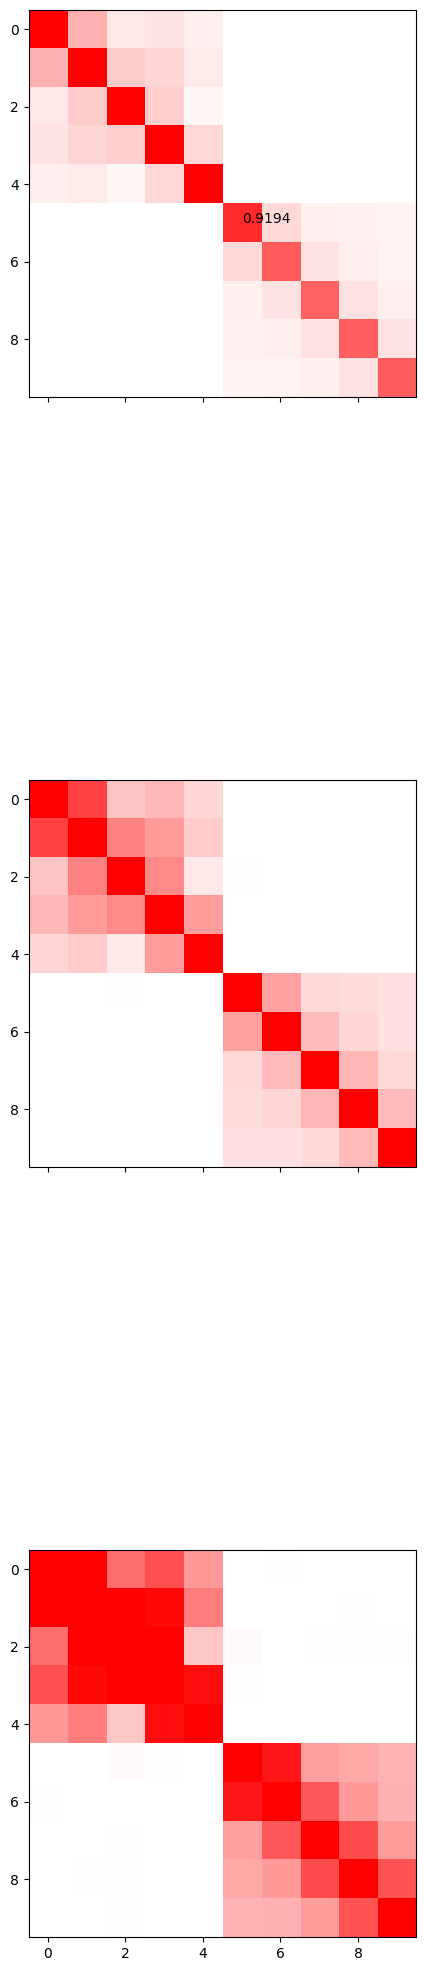

In [ ]:
# Fusions visualization
fig, axs = plt.subplots(3, figsize=(5,30), sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})
hic = hicstraw.HiCFile(files[0])
chroms = hic.getChromosomes()
d1 = breakages[3]
d2 = breakages[7]
vis_matrix, prob = visualizeFusions(hic, chroms[d1[1]].name, d1[2], d1[0], chroms[d2[1]].name, d2[2], d2[0], res, WIDTH, centiles = [95, 90, 80], centiles_results_modified = [], oe_preprocess = [], model=model)
prob = round(prob[0][0], 4) # predicting on the matrix
for data_type in range(vis_matrix.shape[-1]):
  axs[data_type].imshow(vis_matrix[0, :, :, data_type], cmap=br) # plotting input matrices
axs[0].text(5, 5, str(prob)) # printing probability

Finding most likely fusions

In [ ]:
map = np.where(fusion_matrix>break_threshold, 1, 0) # Binarizing fusions

for i in range(len(files)):
  map[i] = map[i]+np.transpose(map[i]) # Converting map for upper triangular matrix to normal matrix

In [ ]:
# Finding the set of indices that correspond to potential fusions (model predicts no break) for each index

def find_lowest_value(matrix, indices):
    lowest_values = []
    for i in range(len(indices)):
        # Removing same index and adjacent indices from the set of most likely free ends
        if i == 0:
          valid_indices = np.setdiff1d(indices, [i, i+1])
        elif i==len(indices)-1:
          valid_indices = np.setdiff1d(indices, [i, i-1])
        else:
          valid_indices = np.setdiff1d(indices, [i, i-1, i+1])

        row = matrix[i]

        if np.min(row[valid_indices]) == 0: # Checking there are potential fusions
          min_indices = np.where(row == 0)[0] # getting free ends that lead to closest fusion
          lowest_values.append([i, [element for element in min_indices if element in valid_indices]]) # If element is a valid index, keep it
    return lowest_values

In [ ]:
# Given a dictionary of each index's preferred indices to be paired with, an optimal pairing is constructed

def pair_elements(preferences):
    pairs = []
    max_cnt = len(preferences)
    cnt = 0
    while preferences and cnt<max_cnt:
      for element, partners in preferences.items():
        # Check if the element has only one preference
        if len(partners) == 1:
            partner = partners[0]
            # Check if the partner also has only one preference and it's the current element
            # print(element, len(preferences.get(partner, [])))
            if len(preferences.get(partner, [])) == 1 and preferences[partner][0] == element:
                pairs.append((element, partner))
                # Remove the paired elements from preferences
                del preferences[element]
                del preferences[partner]
                break
      cnt+=1
    while preferences:
        paired_element = None
        paired_partner = None

        for element, partners in preferences.items():
            # Check if the element has any partners left
            if not partners:
                continue

            # Check if the partner prefers the element
            partner_prefers_element = element in preferences.get(partners[0], [])

            # Check if both prefer each other
            if partner_prefers_element and partners[0] in preferences.get(element, []):
                paired_element = element
                paired_partner = partners[0]
                break

        if paired_element is None or paired_partner is None:
            # No more compatible pairs found, breaking the loop
            break

        # Add the pair to the list
        # print(paired_element, paired_partner)
        # print()
        pairs.append((paired_element, paired_partner))

        # Remove the paired elements from preferences
        del preferences[paired_element]
        del preferences[paired_partner]

        # Remove the paired elements from the preferences of all other elements
        for partners in preferences.values():
            if paired_element in partners:
                partners.remove(paired_element)
            if paired_partner in partners:
                partners.remove(paired_partner)

    return pairs

In [ ]:
# Fusions are the best possible pairings of free ends

fusions = np.zeros(map.shape)
for file_cnt in range(len(files)): # Iterating through each file

  lowest_values = find_lowest_value(map[file_cnt], range(len(breakages))) # list of best possible free ends to fuse with for each free end
  fusion_preferences = {}
  for i in lowest_values:
    fusion_preferences[i[0]] = i[1] # populating the data in lowest_values into a dictionary

  pairs = pair_elements(fusion_preferences) # creating the optimal pairing
  for pair in pairs: # iterating through each pair
    # populating only the upper triangular matrix of fusions (only need each pair of free ends once)
    x = min(pair[0], pair[1])
    y = max(pair[0], pair[1])
    fusions[file_cnt, x, y] = 1

In [ ]:
# Searching for 100% confident fusions (no multiple options)

fusions = np.zeros(map.shape)
for file_cnt in range(len(files)):
  lowest_values = find_lowest_value(map[file_cnt], range(len(breakages)))
  fusion_preferences = {}
  for i in lowest_values:
    fusion_preferences[i[0]] = i[1]

  for i in fusion_preferences:
    if len(fusion_preferences.get(i))==1: # if there is only one preferred partner
      pair = fusion_preferences.get(fusion_preferences.get(i)[0])
      if len(pair)==1 and pair[0]==i: # the partner also only prefers the current index
        # populating only the upper triangular matrix of fusions (only need each pair of free ends once)
        fusions[file_cnt, min(i, fusion_preferences.get(i)[0]), max(i, fusion_preferences.get(i)[0])] = 1

In [ ]:
# Searching for free ends on the same chromosome

fusions = np.zeros(map.shape)
for file_cnt in range(len(files)):

  for i in range(len(breakages)):
    for j in range(i+2, len(breakages)):
      # this means free ends can have multiple fusions, so it is more so detecting if the free ends are on the same chromosome
      if map[file_cnt, i, j]==0:
        fusions[file_cnt, i, j]=1

In [ ]:
# Creating a heatmap of fusions

fusion_heatmap_data = []

for i in range(fusions.shape[1]):
  for j in range(i+2, fusions.shape[2]): # only upper triangular matrix needs to be looked at
    indices_of_ones = np.where(fusions[:, i, j] == 1)[0]
    if not len(indices_of_ones) == 0: # only populate heatmap if at least one of the files has a fusion between the free ends i and j
      fusion_heatmap_data.append([i, j, indices_of_ones])

In [ ]:
xlabels = [str(breakages[i[0]]) + str(breakages[i[1]]) for i in fusion_heatmap_data] # creating x-label indicating which free ends were fused
fusion_data = np.zeros((len(files), len(fusion_heatmap_data)))
fusion_data_probabilities = np.zeros((len(files), len(fusion_heatmap_data)))

for i in range(len(fusion_heatmap_data)):
    fusion_data[fusion_heatmap_data[i][2], i] = 1 # populating the heatmap with 1s where there are fusions
    # populating the heatmap with the probability of the fusion
    fusion_data_probabilities[:, i] = fusion_matrix[:, fusion_heatmap_data[i][0], fusion_heatmap_data[i][1]]

Visualizing fusions and fusions' probability heatmap across all files

In [ ]:
ax = sns.heatmap(data = fusion_data, xticklabels = xlabels, yticklabels = files) # plotting the heatmap
plt.show()

In [ ]:
ax = sns.heatmap(data = fusion_data_probabilities, xticklabels = xlabels, yticklabels = files) # plotting the heatmap
plt.show()

Creating phylogeny - described in the following links:
https://github.com/mcmero/perfect_phylogeny/blob/master/perfect_phylogeny/phylogeny.py

https://mcmero.github.io/blog/Perfect-phylogeny/

In [ ]:
# Algorithm for phylogeny creation

from collections import defaultdict, Counter

# Counting the frequency of each unique column
def find_unique_columns_with_frequencies(data):
    # Convert binary matrix to tuple of columns for easy counting and identify frequencies
    columns = [tuple(col) for col in data.T]
    frequency = Counter(columns)
    # Sort columns by frequency in descending order
    sorted_columns = sorted(frequency.items(), key=lambda x: -x[1])
    print(frequency)
    print(sorted_columns)
    return [item[0] for item in sorted_columns]  # Return only the columns, sorted by frequency

# Removing columns that cannot coexist
# Columns with a higher frequency are prioritized
# 3 possibilities for two columns to coexist
# 1. Column A is a subset of Column B
# 2. Column B is a subset of Column A
# 3. Columns A and B represent points on the phylogeny that are not parent or child points to each other (lie on different branches)
def filter_columns(data, ref_col):
    filtered_data = []

    for col in data.T:
        # Convert tuple to np.array
        col = np.array(col)
        # Check alignment conditions
        condition1 = np.where(ref_col == 1, col == 1, True)
        condition2 = np.where(ref_col == 0, col == 0, True)
        condition3 = np.where(ref_col == 1, col == 0, True)

        if np.all(condition1) or np.all(condition2) or np.all(condition3): # Only one condition needs to be true
            filtered_data.append(col)

    return np.array(filtered_data).T if filtered_data else np.array([], dtype=int)

# Sorting the matrix by frequency and iterating through it to remove all incompatible matrices
def process_data(data):
    original_data = np.array(data)
    results = []

    # Start with the original data as the initial set of columns to filter
    current_data = original_data

    # Get all unique columns sorted by frequency from the original data
    sorted_columns = find_unique_columns_with_frequencies(original_data)

    for ref_col_array in sorted_columns:
        ref_col = np.array(ref_col_array)
        if not np.any(np.all(current_data == ref_col[:, np.newaxis], axis=0)):
          continue
        aligned_data = filter_columns(current_data, ref_col)
        results.append((ref_col, aligned_data))

        # Update current data to the filtered result for the next iteration
        if aligned_data.size == 0 or aligned_data.shape[1] == 0:
            break  # If no columns left or aligned_data is empty, stop the process

        current_data = aligned_data  # Use the newly filtered data for the next reference column

    return results

# Sorting the remaining matrix and keeping only unique columns
def unique_sorted_columns(M):
    powers_of_two = 2**np.arange(M.shape[0])[::-1]
    binary_columns = np.dot(powers_of_two, M)
    unique_indices = np.unique(binary_columns, return_index=True)[1]
    unique_columns = M[:, unique_indices]
    sorted_indices = np.argsort(binary_columns[unique_indices])[::-1]
    sorted_unique_columns = unique_columns[:, sorted_indices]
    return sorted_unique_columns

# k_matrix is described in the links provided
def construct_k_matrix(M_prime):
    # Determine the max number of features plus the '#' and padding
    num_cols = M_prime.shape[1] + 1  # Adding 1 for the '#'

    # Initialize K with zeros
    K = np.zeros((M_prime.shape[0], num_cols), dtype=object)

    for i, row in enumerate(M_prime):
        # Find indices where the feature is present (value is 1)
        feature_indices = np.where(row == 1)[0] + 1  # +1 to make it 1-indexed

        # Fill K with these feature indices
        K[i, :len(feature_indices)] = feature_indices

        # Append '#' after the last feature
        K[i, len(feature_indices)] = '#'

    # Replace remaining zeros with actual zeros (to handle dtype=object)
    K[K == 0] = '0'

    return K

# Writing output file
def write_dot(k1,s,outname):
    '''
    takes a k1 matrix and writes a dot source file of the node
    connections and edges, then converts the dot to a postscript file.
    @param k1 matrix output from perfect phylogeny checking
    @param s samples (rows)
    '''
    dot_lines = []

    for r_idx,k_row in enumerate(k1):
        for c_idx,k_i in enumerate(k_row):
            if k_i=='#': break

            k_next = k_row[c_idx+1]
            if c_idx==0:
                dot_lines.append('\troot [label=""];\n')
                dot_lines.append('\troot -> node_%s [label="%s"];\n' % (k_i,k_i))
            if k_next=='#':
                dot_lines.append('\tnode_%s [label=""];\n' % k_i)
                dot_lines.append('\tnode_%s -> %s;\n' % (k_i,s[r_idx]))
                break
            dot_lines.append('\tnode_%s [label=""];\n\tnode_%s [label=""];\n' % (k_i,k_next))
            dot_lines.append('\tnode_%s -> node_%s [label="%s"];\n' % (k_i,k_next,k_next))

    dot_lines = np.unique(np.array(dot_lines))
    with open('%s.dot'%outname,'w') as fout:
        fout.write('digraph {\n')
        fout.write('\tgraph[size="7.75,10.25"]\n')
        for line in dot_lines:
            fout.write(line)
        fout.write('}\n')


In [ ]:
# Combining breaks and fusions
_ = np.transpose(matrix)
phylogeny_matrix = np.concatenate((_, fusion_data), axis=1)

results = process_data(phylogeny_matrix)
filtered = results[-1][1] # Filtered matrix with only compatible columns

# Get the sorted and unique columns matrix
M_prime = unique_sorted_columns(filtered) # Final group of columns to construct phylogeny with
# Construct the K matrix
K = construct_k_matrix(M_prime)
# Writing output file
write_dot(K, files, 'phylogeny')

In [ ]:
shutil.move("phylogeny.dot", folder_results) # Moving file to folder
# To view dot file, copy its content into this link: https://dreampuf.github.io/GraphvizOnline/